In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go


#for quick viz
import seaborn as sns

#ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import random

In [3]:
#veri setine temizleme işlemleri yapıldı modellemeye hazır hale getirldi.
df = pd.read_csv('auto_insurance_csv.csv')
df = df.drop(['_c39','Unnamed: 0'], axis = 1)
df['umbrella_limit'] = df.umbrella_limit.fillna("9999")
df['police_report_available'] = df.police_report_available.fillna("MISSING")
df['policy_csl'] = df.policy_csl.fillna("MISSING")
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['claim_day_of_policy'] = (df.incident_date -  df.policy_bind_date).dt.days
df['location_check'] = np.nan
df['location_check'] = np.where(df['policy_state'] == df['incident_state'], True, False)
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)
df['umbrella_limit'] = df.umbrella_limit.astype(str)
umbrealla = df['umbrella_limit'].unique()
for umb in umbrealla:
  if (umb != '0.0') & (umb != '9999'):
    df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')
    
hobbies = df['insured_hobbies'].unique()
for hobby in hobbies:
  if (hobby != 'chess') & (hobby != 'cross-fit'):
    df['insured_hobbies'] = df['insured_hobbies'].str.replace(hobby, 'other')

df['age'] = df.age.fillna(9999)
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65','9999']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 9999]

df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels, include_lowest = True)
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']

df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']

df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels)
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']

df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels)

df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium'], axis = 1)
required_columns = ['incident_date','policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount','auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group']
df1 = df[required_columns]

In [4]:
df1.incident_date.count()

1000

### Train & Test & Validation

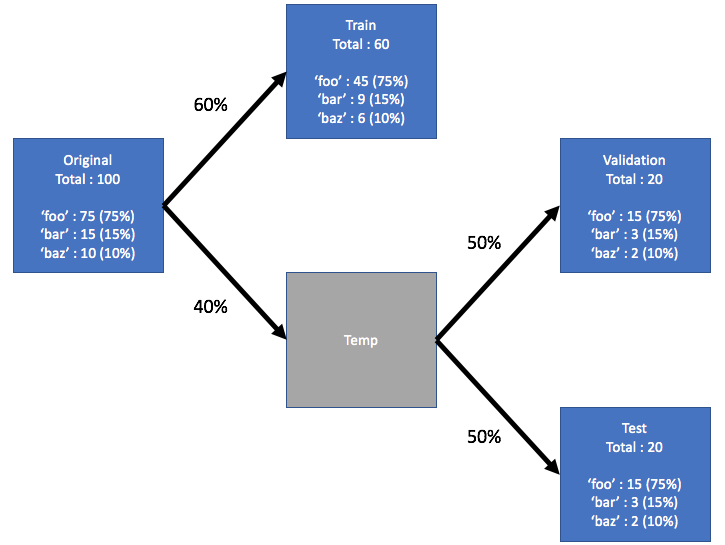

In [5]:
# Veri setini train&test&validation olarak ayırma
df1_val = df1.sort_values(by='incident_date',ascending=False).head(200) # validation
df2 = df1.sort_values(by='incident_date',ascending=False).tail(800)

df1_val = df1_val.drop(["incident_date"],axis=1)
df2 = df2.drop(["incident_date"],axis=1)

In [6]:
df1_val.shape

(200, 35)

## Dengesiz veri kümlerini işleme
### 1. Dengesiz veri seti nedir?
 Sınıflardan biri çok az örnekle temsil edilirken diğer sınıfın çok sayıda örnekle temsil edilmesidir. Bu durum tahminlemede soruna sebep olur, verisi az olan örnekler modelde yeterince eğitlemediğinden hatalı tahmin sonuçları gelebilir.

 Sınıflandıma algoritmalarının amacı genel doğruluğu maksimize etmek olduğundan, sınıflandırıcı veri sayısı çok olan sınıfı  daha iyi öğrenecektir ve bu eğitimin sonucu çoğunluk sınıfı için düşük hata oranı, ancak azınlık sınıfı için daha yüksek hata oranı olacaktır. Özetle, sınıflandırıcı tüm örnekleri yüksek doğruluk sağlayan çoğunluk olarak sınıflandırma eğiliminde olacak, ancak bu arada azınlık örneklerini kaçıracaktır.

### 1) One hot encoding modelin görmediği veriye nasıl uygulanır?

Eğitim veri kümesi ve test veri kümesi belirli bir özellik için farklı sayıda benzersiz değere sahipse bu her veri kümesi için farklı sayıda bir One-hot encoding ile sonuçlanır. 


- **Çözüm 1: get_dummies** yerine **pandas.factorize()** kullanarak n sayıda sütun döndürerek değil, tek satırda döndürerek bu sorunu çözebiliriz.

- **Çözüm 2:** 2 veri kümesini(Train, test) birleştirerek kodlama yapmak bir çözüm olabilir.

Her iki veri setinde yeni bir sütun oluşturup 1 ve 0 atayıp,  birleştiririz.

train["train"]=1

test["test"]=0

combined =pd.concat([train, test])

get_dummies uygulanır ardından veri seti ayrılır, eklenen sütunlar silinir.

*Aşağıdaki durumlarda One-Hot Encoding uygularız:*

- Kategorik özellik sıralı değildir (ülkeler gibi).

- Kategorik özelliklerin sayısı daha azdır, bu nedenle One-Hot Encoding etkili bir şekilde uygulanabilir.

*Aşağıdaki durumlarda Label Encoding uygularız:*

- Kategorik özellik sıralıdır (, İlkokul, lise gibi).

- Tek etkin kodlama yüksek bellek tüketimine yol açabileceğinden kategori sayısı oldukça fazladır.


### 2) Labelencoding'de ilgili kolon için ölçeklendirme nasıl yapılır? 

Label Encoding işlemi sonrası sayısal değerler alan kategoriler, algoritmalar tarafından içlerinde bir tür düzen varmış gibi yanlış değerlendirilebilir. Sıralanabilir kategoriler olmadığında bu model sonuçlarında yanıtılcı olabilir. Sıralanabilir katagoriler de ise kategorilerin bağımlı değiken ile ilşikileri göz önünde bulundurularak ölçeklendirilmelidir. 

## Encoding

In [7]:
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group']
for col in cat_cols:
  df1[col] = df1[col].astype('object')

columns_to_encode = []
for col in df1.columns:
  if df1[col].dtype == 'object':
    columns_to_encode.append(col)

columns_to_encode

<ipython-input-7-4a0a6353d295>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col] = df1[col].astype('object')


['policy_state',
 'policy_csl',
 'umbrella_limit',
 'insured_sex',
 'insured_education_level',
 'insured_occupation',
 'insured_hobbies',
 'insured_relationship',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'incident_state',
 'incident_city',
 'incident_location',
 'property_damage',
 'police_report_available',
 'auto_make',
 'auto_model',
 'location_check',
 'age_group',
 'months_as_customer_groups',
 'policy_annual_premium_groups',
 'policy_deductable_group']

In [8]:
# train veri setine pd.factorize metodu ile encoding işlemi.
df3 = df2.copy()
for i in columns_to_encode:
    df3[i] = pd.factorize(df2[i])[0]

In [9]:
df2.head()

,policy_state,policy_csl,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,...,auto_make,auto_model,auto_year,fraud_reported,claim_day_of_policy,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
511,OH,MISSING,0.0,446755,FEMALE,JD,sales,other,husband,0,...,Volkswagen,Jetta,2003,0,4427,False,46-50,251-300,medium,501-1000
894,IN,MISSING,0.0,475891,MALE,MD,priv-house-serv,other,not-in-family,0,...,Suburu,Impreza,2000,0,8921,False,31-35,0-50,medium,0-500
125,IN,MISSING,other,603948,MALE,JD,craft-repair,other,unmarried,47200,...,Ford,Escape,2013,0,205,False,36-40,201-250,medium,501-1000
895,IL,MISSING,0.0,462525,MALE,High School,armed-forces,other,own-child,26500,...,Saab,92x,1998,1,1980,False,36-40,151-200,medium,0-500
485,IN,MISSING,0.0,471366,MALE,Associate,adm-clerical,other,husband,0,...,Nissan,Maxima,1995,0,7692,False,26-30,51-100,medium,1501-2000


In [10]:
df3.head()

,policy_state,policy_csl,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,...,auto_make,auto_model,auto_year,fraud_reported,claim_day_of_policy,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
511,0,0,0,446755,0,0,0,0,0,0,...,0,0,2003,0,4427,0,0,0,0,0
894,1,0,0,475891,1,1,1,0,1,0,...,1,1,2000,0,8921,0,1,1,0,1
125,1,0,1,603948,1,0,2,0,2,47200,...,2,2,2013,0,205,0,2,2,0,0
895,2,0,0,462525,1,2,3,0,3,26500,...,3,3,1998,1,1980,0,2,3,0,1
485,1,0,0,471366,1,3,4,0,0,0,...,4,4,1995,0,7692,0,3,4,0,2


In [11]:
# encoding uygulanmamış değişken kontrolü
cols = df3.columns
num_cols = df3._get_numeric_data().columns
list(set(cols) - set(num_cols))

[]

### Bağımlı ve bağımsız değişkenler

In [12]:
features = []
for col in df3.columns:
    if col != 'fraud_reported':
        features.append(col)

target = 'fraud_reported'

X = df3[features]
y = df3[target]

### Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

In [14]:
X

array([[-1.21032107, -0.36229023, -0.70394734, ..., -1.3192    ,
        -0.62654063, -1.18668721],
       [-0.00751752, -0.36229023, -0.70394734, ..., -0.93875299,
        -0.62654063,  0.04304047],
       [-0.00751752, -0.36229023,  0.53376227, ..., -0.55830598,
        -0.62654063, -1.18668721],
       ...,
       [ 1.19528602,  0.96721521,  1.77147188, ...,  1.72437606,
         0.6619748 ,  1.27276815],
       [-0.00751752,  3.62622608, -0.70394734, ...,  0.58303504,
         1.95049024,  0.04304047],
       [-1.21032107, -0.36229023, -0.70394734, ..., -0.93875299,
         0.6619748 ,  0.04304047]])

### Denegsiz veri setinde modelleme

<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

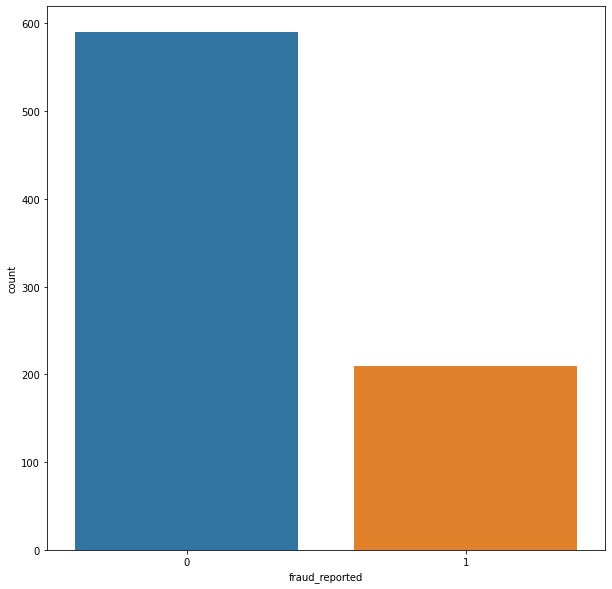

In [15]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 10))
sns.countplot(x='fraud_reported',data=df3)

### 3) Imbalance datasette train test split yaparken neleri göz önünde bulundurmalıyız?

-  Dengesiz veri kümeleriyle karşılaştığımız durumlarda Örneğin kredi kartlarıyla yapılan ödemelerdeki dolandırıcılık vakalarını, network saldırılarını belirlemede ve az rastlanır hastalıkların teşhis edilmesinde, algoritmaların tahmin gücü azalıyor. Bu durumlarda asıl hedef genellikle azınlık olan sınıfı doğru sınıflandırabilmek olduğu için, dengesiz veri kümeleriyle çalışırken dikkat etmemiz gereken noktalar önem kazanıyor.
-  Veri setinin train ve test veri seti olarak bölünmesi sırasında hedef nitelige ait sınıfın train ve test veri setlerindeki dagılımına özen gösterilmelidir.
-  Egitim veri setindeki örneklerin sayıca test veri setindeki örneklerden fazla olması beklenir. Makine ögrenmesinde, algoritma ne kadar çok veri ile eğitilirse algoritmanın ögrenme performansı da o kadar artacaktır. 
-  Egitim ve test veri seti ayrımında örneklerin rastgele dagılması önemlidir. Eger örnekler elle müdahale edilerek egitim ve test veri setlerine dagıtılıyorsa, bu durum yapılacak analizin güvenilirligine gölge düsürecektir.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Test&train ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,  random_state = 42)

In [18]:
print("X_train size: ", X_train.shape)
print("X_test size: ", X_test.shape)
print("y_train size: ", y_train.shape)
print("y_test size: ", y_test.shape)

X_train size:  (600, 34)
X_test size:  (200, 34)
y_train size:  (600,)
y_test size:  (200,)


C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

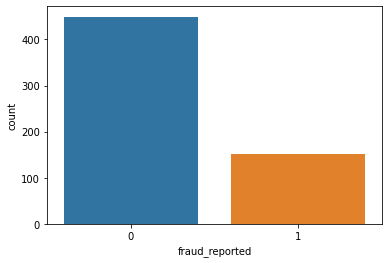

In [19]:
chck = pd.DataFrame()
chck['fraud_reported'] = y_train

sns.countplot(chck['fraud_reported'])

Dengesiz veri setleriyle karşılaştığımızda doğru gözlem yapabilmek ve dengeyi sağlayabilmek için uygulayabileceğimiz çeşitli yöntemler vardır:
- Doğru metrik seçimi
- Resampling
- Hyperparameter tuning

Random Forest MODEL
Score: 82.0

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       141
           1       0.83      0.49      0.62        59

    accuracy                           0.82       200
   macro avg       0.82      0.72      0.75       200
weighted avg       0.82      0.82      0.80       200



<AxesSubplot:>

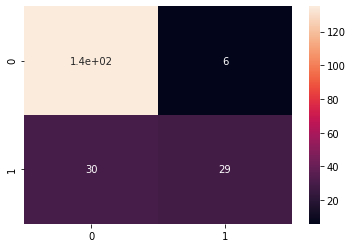

In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

preds = rfc.predict(X_test)

print("Random Forest MODEL")
score = rfc.score(X_test, y_test)
print("Score:",score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

SVC MODEL
Score: 86.5
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       141
           1       0.79      0.75      0.77        59

    accuracy                           0.86       200
   macro avg       0.84      0.83      0.84       200
weighted avg       0.86      0.86      0.86       200



<AxesSubplot:>

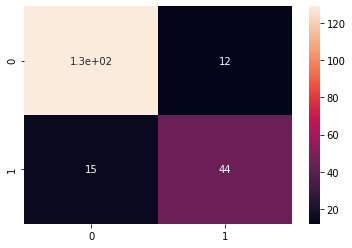

In [21]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

preds = svc.predict(X_test)

print("SVC MODEL")
print('Score:' ,( svc.score(X_test, y_test)*100))
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

Confusion Matrix'i incelediğimizde Fraud değerlerin yanlış tahminleme sayısı yüksek çıkmış, model Non fraud yani çoğunluk sınıfı tahmin etmekte başarılıdır.

- **Precision** : Pozitif olarak tahmin edilenlerin ne kadarının gerçekte pozitif olduğunu gösterir.
- **Recall** : Pozitif olarak tahmin etmemiz gereken değerlerin ne kadarını pozitif tahmin ettiğimizi gösterir.
- **F1 score** : Precision ve Duyarlılık değerlerinin harmonik ortalamasını göstermektedir.

- **Resampling** :Yeniden örnekleme, azınlık sınıfına yeni örnekler ekleyerek veya çoğunluk sınıfından örnekler çıkarılarak veri setinin daha dengeli hale getirilmesidir.

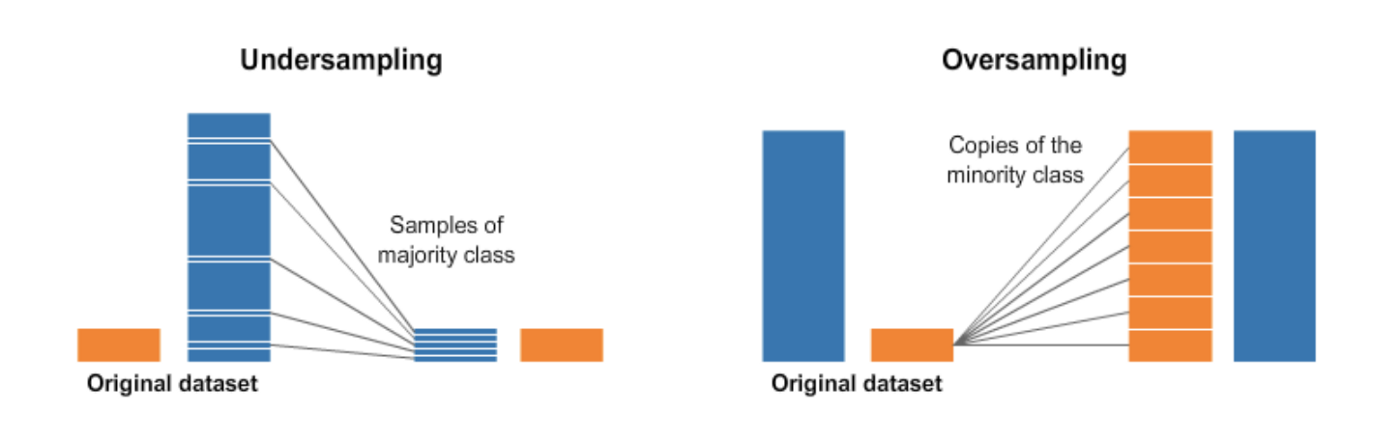

In [22]:
# random oversampling önce eğitim setindeki sınıf sayısı
y_train.value_counts()

0    449
1    151
Name: fraud_reported, dtype: int64

In [23]:
#random oversampling 
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler( random_state=9)
X_randomover, y_randomover = oversample.fit_resample(X_train, y_train)

In [24]:
# oversampling sonrası eğitim setindeki sınıf sayısı
y_randomover.value_counts()

1    449
0    449
Name: fraud_reported, dtype: int64

Random Forest MODEL
Score: 87.5

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       141
           1       0.81      0.75      0.78        59

    accuracy                           0.88       200
   macro avg       0.86      0.84      0.85       200
weighted avg       0.87      0.88      0.87       200



<AxesSubplot:>

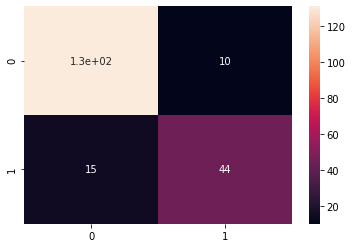

In [25]:
rfc.fit(X_randomover, y_randomover)
y_pred = rfc.predict(X_test)

preds = rfc.predict(X_test)

print("Random Forest MODEL")
score = rfc.score(X_test, y_test)
print("Score:",score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

SVC MODEL
Score: 86.5
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       141
           1       0.72      0.88      0.79        59

    accuracy                           0.86       200
   macro avg       0.83      0.87      0.85       200
weighted avg       0.88      0.86      0.87       200



<AxesSubplot:>

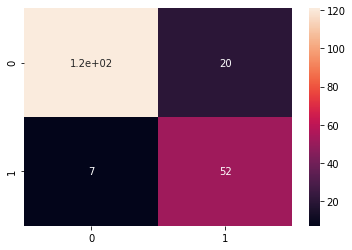

In [26]:
svc = SVC(kernel='linear')
svc.fit(X_randomover, y_randomover)

preds = svc.predict(X_test)

print("SVC MODEL")
print('Score:' ,( svc.score(X_test, y_test)*100))
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

İlk modele göre Non fraud sınıfının tahmin edilme başarısı düşmüş fakat fraud sınıfının doğru tahmin edilmesindeki yükselme randomoversampling yapıldıktan sonra oluşturulmuş model tercih edilebilir.

- **SMOTE Oversampling**: Overfitting’i önlemek için azınlık sınıfından sentetik örnekler oluşturulması.

In [27]:
# smote dan önce eğitim setindeki sınıf sayısı
y_train.value_counts()

0    449
1    151
Name: fraud_reported, dtype: int64

In [28]:
# Smote uygulanması 
from imblearn.over_sampling import SMOTE
smotesample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

In [29]:
# smote dan sonra eğitim setinin sınıf sayısı
y_smote.value_counts()

1    449
0    449
Name: fraud_reported, dtype: int64

Random Forest MODEL
Score: 87.5

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       141
           1       0.81      0.75      0.78        59

    accuracy                           0.88       200
   macro avg       0.86      0.84      0.85       200
weighted avg       0.87      0.88      0.87       200



<AxesSubplot:>

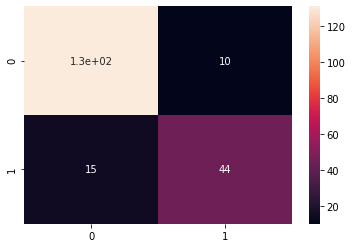

In [30]:
rfc.fit(X_smote, y_smote)
y_pred = rfc.predict(X_test)

preds = rfc.predict(X_test)

print("Random Forest MODEL")
score = rfc.score(X_test, y_test)
print("Score:",score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

SVC MODEL
Score: 86.5
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       141
           1       0.72      0.88      0.79        59

    accuracy                           0.86       200
   macro avg       0.83      0.87      0.85       200
weighted avg       0.88      0.86      0.87       200



<AxesSubplot:>

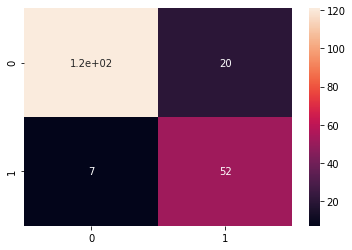

In [31]:
svc = SVC(kernel='linear')
svc.fit(X_smote, y_smote)

preds = svc.predict(X_test)

print("SVC MODEL")
print('Score:' ,( svc.score(X_test, y_test)*100))
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

- **Undersampling** : Çoğunluk sınıfına ait örneklerin çıkarılmasıyla veri setini dengeleme tekniğidir. 

In [32]:
# random undersampling den önce eğitim setindeki sınıf sayısı
y_train.value_counts()

0    449
1    151
Name: fraud_reported, dtype: int64

In [33]:
# random undersampling
from imblearn.under_sampling import RandomUnderSampler
ranUnSample = RandomUnderSampler()
X_ranUnSample, y_ranUnSample = ranUnSample.fit_resample(X_train, y_train)

In [34]:
# Random undersampling sonra
y_ranUnSample.value_counts()

1    151
0    151
Name: fraud_reported, dtype: int64

Random Forest MODEL
Score: 88.0

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       141
           1       0.77      0.85      0.81        59

    accuracy                           0.88       200
   macro avg       0.85      0.87      0.86       200
weighted avg       0.88      0.88      0.88       200



<AxesSubplot:>

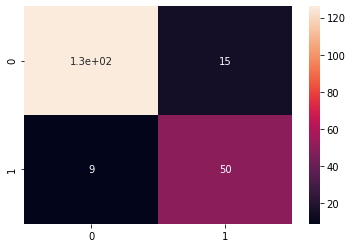

In [35]:
rfc.fit(X_ranUnSample, y_ranUnSample)
y_pred = rfc.predict(X_test)

preds = rfc.predict(X_test)

print("Random Forest MODEL")
score = rfc.score(X_test, y_test)
print("Score:",score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

SVC MODEL
Score: 85.0
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       141
           1       0.70      0.86      0.77        59

    accuracy                           0.85       200
   macro avg       0.82      0.85      0.83       200
weighted avg       0.87      0.85      0.85       200



<AxesSubplot:>

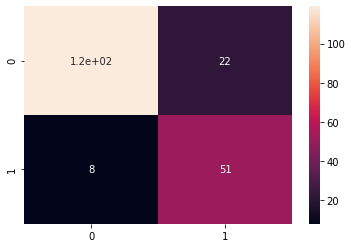

In [36]:
svc = SVC(kernel='linear')
svc.fit(X_ranUnSample, y_ranUnSample)

preds = svc.predict(X_test)

print("SVC MODEL")
print('Score:' ,( svc.score(X_test, y_test)*100))
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

### 5) predict_proba metoduyla oran nasıl hesaplanır ve treshold nasıl değiştirilir?

Regresyon, sınıflandırma, kümeleme gibi yöntemler kullanarak yapacağınız çalışmalarda tahmin edilen etiket bilgisini predict fonksiyonuyla elde edebilirsiniz. Sınıflandırma problemlerinde gözlemlerin sınıflara ait olma olasılıklarını elde etmek istiyorsanız predict_proba fonksiyonunu kullanmanız gerekiyor.

Scikit öğrenmede eşik, ikili sınıflandırma için 0,5'tir ve çok sınıflı sınıflandırma için hangi sınıf en büyük olasılığa sahipse şeklindedir. Bir çok problemde eşiği ayarlayarak çok daha iyi bir sonuç elde edilebilir. 

In [37]:
# test veri setinin etiket oranları
rfc.predict_proba(X_test)[:10]

array([[0.33, 0.67],
       [0.54, 0.46],
       [0.23, 0.77],
       [0.78, 0.22],
       [0.67, 0.33],
       [0.71, 0.29],
       [0.76, 0.24],
       [0.62, 0.38],
       [0.65, 0.35],
       [0.25, 0.75]])

In [38]:
# Smote resampling uygulanmış veri seti predict proba değerleri
rfc.predict_proba(X_smote)[:10]

array([[0.88, 0.12],
       [0.11, 0.89],
       [0.88, 0.12],
       [0.63, 0.37],
       [0.46, 0.54],
       [0.76, 0.24],
       [0.78, 0.22],
       [0.07, 0.93],
       [0.66, 0.34],
       [0.33, 0.67]])

In [39]:
rfc.predict(X_smote)[:10]

array([0, 1, 0, 0, 1, 0, 0, 1, 0, 1])

- **Threshol değiştirme**

In [40]:
# en iyi Thershold değeri bulma
from sklearn.metrics import f1_score
from numpy import arange
from numpy import argmax
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
 
rfc.fit(X_smote, y_smote)
# predict probabilities
yhat = rfc.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.371, F-Score=0.83200


Random Forest MODEL
Score: 87.5

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       141
           1       0.81      0.75      0.78        59

    accuracy                           0.88       200
   macro avg       0.86      0.84      0.85       200
weighted avg       0.87      0.88      0.87       200



<AxesSubplot:>

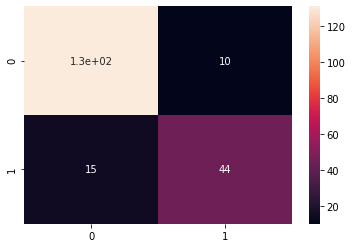

In [41]:
rfc.fit(X_smote, y_smote)
y_pred = (rfc.predict_proba(X_test)[:,1] >= 0.371).astype(bool)

preds = rfc.predict(X_test)

print("Random Forest MODEL")
score = rfc.score(X_test, y_test)
print("Score:",score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

- **Hyperparameter tuning**

In [42]:
#GridsearchCV SVC
from sklearn.model_selection import GridSearchCV
 
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.742 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.808 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.808 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.825 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.808 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.792 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [43]:
# Tuning işleminden sonra best parametreler
print(grid.best_params_)
 
# hyper-parameter 
print(grid.best_estimator_)

{'C': 100, 'gamma': 1, 'kernel': 'linear'}
SVC(C=100, gamma=1, kernel='linear')


SVC MODEL
Score: 86.5
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       141
           1       0.79      0.75      0.77        59

    accuracy                           0.86       200
   macro avg       0.84      0.83      0.84       200
weighted avg       0.86      0.86      0.86       200



<AxesSubplot:>

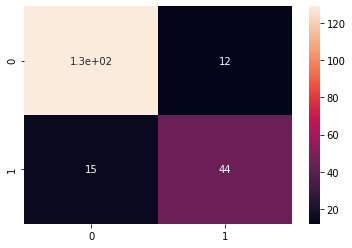

In [59]:
svc_CV = SVC(C=100, gamma=1, kernel='linear')# hiperparametre ile model denemesi
svc_CV.fit(X_train, y_train)

preds = svc_CV.predict(X_test)

print("SVC MODEL")
print('Score:' ,( svc_CV.score(X_test, y_test)*100))
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

In [51]:
#GridsearchCV Randomforest
param_grid = { 
    'n_estimators': [150, 200, 300,],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,7,8,10],
    'criterion' :['gini', 'entropy']}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)

CV_rfc.fit(X_randomover, y_randomover)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 7, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [150, 200, 300]})

In [53]:
# Tuning işleminden sonra best parametreler
print(CV_rfc.best_params_)
 
# hyper-parameter 
print(CV_rfc.best_estimator_)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 150}
RandomForestClassifier(max_depth=10, n_estimators=150, random_state=1)


Random Forest MODEL
Score: 86.5

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       141
           1       0.79      0.75      0.77        59

    accuracy                           0.86       200
   macro avg       0.84      0.83      0.84       200
weighted avg       0.86      0.86      0.86       200



<AxesSubplot:>

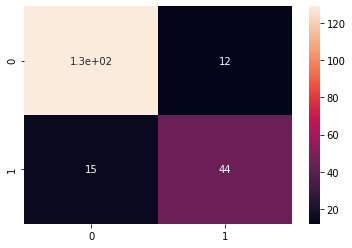

In [60]:
rfc_CV = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=150,max_features= 'auto',random_state=1)
rfc_CV.fit(X_randomover, y_randomover)

preds = rfc_CV.predict(X_test)

print("Random Forest MODEL")
score = rfc_CV.score(X_test, y_test)
print("Score:",score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

In [61]:
#GridsearchCV SVC smote resampling veri seti
from sklearn.model_selection import GridSearchCV
 
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf','linear']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
grid.fit(X_smote, y_smote)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.561 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.678 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.683 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.497 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.497 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.794 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.844 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.872 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.810 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.860 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.706 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [62]:
# Tuning işleminden sonra best parametreler
print(grid.best_params_)
 
# hyper-parameter 
print(grid.best_estimator_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1, gamma=1)


SVC MODEL
Score: 87.0
              precision    recall  f1-score   support

           0       0.95      0.87      0.90       141
           1       0.73      0.88      0.80        59

    accuracy                           0.87       200
   macro avg       0.84      0.87      0.85       200
weighted avg       0.88      0.87      0.87       200



<AxesSubplot:>

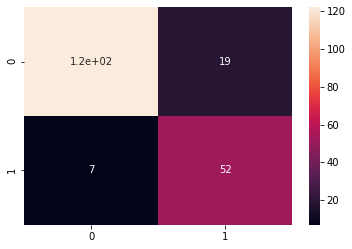

In [68]:
svc_CVsmote = SVC(C=1000, gamma=1, kernel='linear')# hiperparametre ile model denemesi
svc_CVsmote.fit(X_smote, y_smote)

preds = svc_CVsmote .predict(X_test)

print("SVC MODEL")
print('Score:' ,(svc_CVsmote.score(X_test, y_test)*100))
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

### 4) Validation dataseti (modelin görmediği) nasıl oluşturulur ve nasıl predict etmeye hazır hale getirilir?

SVC MODEL
Score: 85.91549295774648
              precision    recall  f1-score   support

           0       0.94      0.78      0.85        37
           1       0.80      0.94      0.86        34

    accuracy                           0.86        71
   macro avg       0.87      0.86      0.86        71
weighted avg       0.87      0.86      0.86        71



<AxesSubplot:>

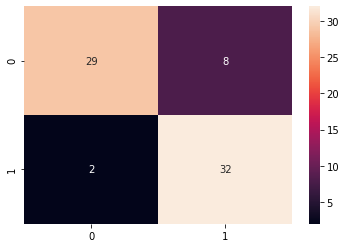

In [69]:
# validasyon veri setine uygulama
df1_val.head()

# encoding
df4 = df1_val.copy()
for i in columns_to_encode:
    df4[i] = pd.factorize(df1_val[i])[0]
    
#bağımlı bağımsız değişken ayrımı
features = []
for col in df4.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X = df4[features]
y = df4[target]

# scale
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state = 42)

# resampling
from imblearn.over_sampling import SMOTE
smotesample = SMOTE()

X_smote, y_smote = oversample.fit_resample(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.3, random_state = 1)

# model
svc_CVsmote = SVC(C=1000, gamma=1, kernel='linear')
svc_CVsmote.fit(X_smote, y_smote)

preds = svc_CVsmote .predict(X_test)

print("SVC MODEL")
print('Score:' ,(svc_CVsmote.score(X_test, y_test)*100))
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

### Sonuç: 
Dengesiz veri setinde resampling yöntemlerinden SMOTE, model olraka SVC modeli kullanılmıştır. Confusion Matrix'i incelediğimizde Fraud olup fraud değil dediğimiz 2 değer olduğunu görüyoruz,fraud olup fraud tahmin ettiğimiz ise 32 değer çıkmış.